Benjamin Ye  
CS/CNE/EE 156a: Learning Systems (Fall 2023)  
October 23, 2023

## Homework 4

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, globals()['_dh'][0].resolve().parent)
from cs156a import (
    vapnik_chervonenkis_bound, rademacher_bound,
    parrondo_van_den_broek_bound, devroye_bound, generate_data
)

mpl.rcParams.update(
    {
        "axes.labelsize": 14,
        "figure.autolayout": True,
        "figure.figsize": (4.875, 3.65625),
        "font.size": 12,
        "legend.columnspacing": 1,
        "legend.edgecolor": "1",
        "legend.framealpha": 0,
        "legend.fontsize": 12,
        "legend.handlelength": 1.25,
        "legend.labelspacing": 0.25,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True
    }
)

### Problems 2–3


[HW4 P2–3]
Generalization bounds for d_vc=50 and delta=0.05:
  N=10,000:
    Vapnik–Chervonenkis: 0.632
    Rademacher: 0.331
    Parrondo–van den Broek: 0.224
    Devroye: 0.215
  N=5:
    Vapnik–Chervonenkis: 13.828
    Rademacher: 7.049
    Parrondo–van den Broek: 5.101
    Devroye: 5.593


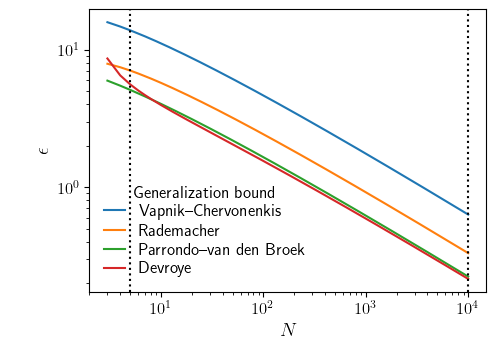

In [2]:
d_vc = 50
delta = 0.05
m_H = lambda N: N ** d_vc
Ns = np.arange(3, 10_001, dtype=float)
bounds = {
    "Vapnik–Chervonenkis": vapnik_chervonenkis_bound(m_H, Ns, delta),
    "Rademacher": rademacher_bound(m_H, Ns, delta),
    "Parrondo–van den Broek": parrondo_van_den_broek_bound(m_H, Ns, delta),
    "Devroye": devroye_bound(lambda N: d_vc * np.log(N), Ns, delta, log=True)
}

_, ax = plt.subplots()
for l, b in bounds.items():
    ax.plot(Ns, b, label=l)
ax.set_yscale("log")
ylim = ax.get_ylim()

print(f"\n[HW4 P2–3]\nGeneralization bounds for {d_vc=} and {delta=}:")
for N in (10_000, 5):
    i = np.where(Ns == N)[0][0]
    print(f"  {N=:,}:")
    for l, b in bounds.items():
        print(f"    {l}: {b[i]:.3f}")
    ax.plot((N, N), ylim, "k:")

ax.legend(title="Generalization bound")
ax.set_xlabel("$N$")
ax.set_xscale("log")
ax.set_ylabel("$\epsilon$")
ax.set_ylim(ylim)
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
plt.show()

#### Problems 4–6

In [3]:
n_runs = 10_000_000
x, y = generate_data(2 * n_runs, lambda x: np.sin(np.pi * x), 1)
as_ = (x[::2] * y[::2] + x[1::2] * y[1::2]) / (x[::2] ** 2 + x[1::2] ** 2)
a_avg = as_.mean()
x, y = generate_data(2 * n_runs, lambda x: np.sin(np.pi * x), 1)
print(f"\n[HW4 P4–6]\nBias and variance of h(x)=ax for f(x)=sin(pi*x):\n"
      f"  g(x)={a_avg:.2f}x, bias={((a_avg * x - y) ** 2).mean():.3f}, "
      f"var={(((np.tile(as_, (2, 1)) - a_avg) * x) ** 2).mean():.3f}")


[HW4 P4–6]
Bias and variance of h(x)=ax for f(x)=sin(pi*x):
  g(x)=1.43x, bias=0.271, var=0.237
